In [1]:
%cd ..
!pwd

/dcs/21/u2110391/CS407/Machine-Unlearning-x-Continual-Learning
/dcs/21/u2110391/CS407/Machine-Unlearning-x-Continual-Learning


/dcs/21/u2110391/CS407/Machine-Unlearning-x-Continual-Learning/.venv/lib64/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/dcs/21/u2110391/CS407/Machine-Unlearning-x-Continual-Learning/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


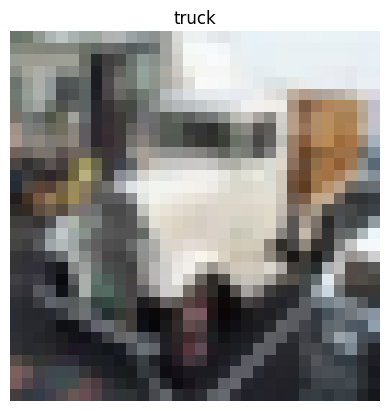

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes 
from torch.utils.data import DataLoader
import random
import os
import sys
sys.path.append(os.path.abspath("."))  # Adds the current directory
# from GEM.gem import *
from GEM.args import *
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
import quadprog

# CIFAR-10

In [3]:
# Path to the dataset
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# split the data into 10 classes by doing sort by key where in the keys are the labels and the values are the data
train_split = {cls: [] for cls in CLASSES}
for img, label in zip(train_data, train_labels):
    train_split[CLASSES[label]].append(img)
    
# this makes more sense to me, effectively indexes 0-5000 are all airplanes, 5000-10000 are all automobiles etc
test_split = {cls: [] for cls in CLASSES}
for img, label in zip(test_data, test_labels):
    test_split[CLASSES[label]].append(img)

# PRETRAINED MODEL

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
# make cuda available if available

from cifar import load_cifar10_data, show_image

# we want to create a resnet 18 model for 32x32 images
# avoid upscaling, the model will take 32x32 images on input as opposed to 224x224

initialisation = time.time()

class ResNet18CIFAR(torch.nn.Module):
    def __init__(self):
        super(ResNet18CIFAR, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # change the first layer to accept 32x32 images with 3 channels rather than 224x224 images
        # check the size of the input layer
        print("|| conv1 weight size: ", self.resnet.conv1.weight.size())
        print("|| fc weight size: ", self.resnet.fc.weight.size())
        self.resnet.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.resnet.fc = torch.nn.Linear(512, 10)
        self.resnet.maxpool = torch.nn.Identity()
        # change input layer to accept 32x32 images


        
        # List all layers in the resnet18 model
        for name, layer in self.resnet.named_children():
            print(f"Layer: {name} -> {layer}")
        
        #print("|| conv1 weight size: ", self.resnet.conv1.weight.size())
        #print("|| fc weight size: ", self.resnet.fc.weight.size())

    def forward(self, x):
        return self.resnet(x)

In [5]:
model = torch.load('models/resnet18_cifar77ACC.pth',  map_location=torch.device('cpu'))
model.eval()

ResNet18CIFAR(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

# INITIAL MODEL EVALUATION

In [7]:
# turn the data into a tensor
test_data_tensor = torch.tensor(test_data).float()
test_labels_tensor = torch.tensor(test_labels)

# keep track of accuracy
correct1 = 0
correct2 = 0
total1 = len(train_data)
total2 = len(test_data)

# start test/train accuracy timer
accuracy = time.time()

print("||===================START TEST/TRAIN ACCURACY=================||")

# move tensors to GPU if available
if torch.cuda.is_available():
    test_data_tensor = test_data_tensor.cuda()
    test_labels_tensor = test_labels_tensor.cuda()
    
            
# test the model
with torch.no_grad():
    for i in range(0, len(test_data), 1000):
        # get the input and output
        img = test_data_tensor[i:i+1000]
        label = test_labels_tensor[i:i+1000]
        

        # normalise the image
        #img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)

        # get the prediction
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)

        # get the number of correct predictions
        correct2 += (predicted == label).sum().item()
        
        del img

# print the accuracy
print(f"|| Test Set Accuracy: {correct2 / total2 * 100:.2f}%")

print("||==============================END==========================||")

# calculate the time taken to get the accuracy
accuracy = time.time() - accuracy

# print timing information
print(f"|| Time to load data: {initialisation:.2f}s")
print(f"|| Time to get accuracy: {accuracy:.2f}s")
print(f"|| Total time: {initialisation + accuracy:.2f}s")

print("||==============================END==========================||")

||===================START TEST/TRAIN ACCURACY=================||
|| Test Set Accuracy: 77.34%
||==============================END==========================||
|| Time to load data: 1731559331.98s
|| Time to get accuracy: 57.80s
|| Total time: 1731559389.78s
||==============================END==========================||


# UNLEARNING

In [6]:
import copy
umodel = copy.deepcopy(model)
%cd Unlearning/

/dcs/21/u2110391/CS407/Machine-Unlearning-x-Continual-Learning/Unlearning


/dcs/21/u2110391/CS407/Machine-Unlearning-x-Continual-Learning/.venv/lib64/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
from unlearn.scrub import train_distill, iterative_unlearn, scrub
from utils import DistillKL, AverageMeter, accuracy
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, ConcatDataset, Subset

# Convert the data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from unlearn.RL import RL

# Assume 'train_data' and 'train_labels' are your training data and labels
# 'test_data' and 'test_labels' are your test data and labels
# 'model' is your pretrained ResNet model

# Define the class you want to unlearn
class_to_unlearn = 0  # Change this to the class you want to unlearn


# Convert data and labels to tensors if they aren't already
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels)

# Create TensorDatasets directly for 'forget' and 'retain' subsets
forget_indices = (train_labels_tensor == class_to_unlearn).nonzero(as_tuple=True)[0]
retain_indices = (train_labels_tensor != class_to_unlearn).nonzero(as_tuple=True)[0]

# Create 'forget' dataset
forget_data = train_data_tensor[forget_indices]
forget_labels = train_labels_tensor[forget_indices]
forget_dataset = TensorDataset(forget_data, forget_labels)

# Create 'retain' dataset
retain_data = train_data_tensor[retain_indices]
retain_labels = train_labels_tensor[retain_indices]
retain_dataset = TensorDataset(retain_data, retain_labels)

# Create DataLoaders
forget_loader = DataLoader(forget_dataset, batch_size=64, shuffle=True)
retain_loader = DataLoader(retain_dataset, batch_size=64, shuffle=True)

# Prepare the data_loaders dictionary
data_loaders = {'forget': forget_loader, 'retain': retain_loader}

# Create the test DataLoader
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Move the model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

class Args:
    def __init__(self):
        self.unlearn_lr = 0.1         # Learning rate for unlearning
        self.momentum = 0.9
        self.weight_decay = 5e-4
        self.dataset = ''      # Change as needed
        self.num_classes = 10         # Number of classes in the dataset
        self.batch_size = 64
        self.print_freq = 10
        self.warmup = 0               # Number of warmup epochs
        self.imagenet_arch = False    # Set to True if using ImageNet architecture
        self.seed = 42                # For reproducibility


        # Add the following attributes to ensure compatibility
        self.decreasing_lr = '50,75'  # Comma-separated epochs where LR decays
        self.rewind_epoch = 0         # Epoch to rewind to; set to 0 if not using rewinding
        self.rewind_pth = ''          # Path to the rewind checkpoint
        self.gpu = 0                  # GPU ID to use; adjust as needed
        self.surgical = False         # Whether to use surgical unlearning
        self.choice = []              # Layers to unlearn surgically; list of layer names
        self.unlearn = 'retrain'      # Unlearning method, e.g., 'retrain'
        self.unlearn_epochs = 10     # Number of epochs for unlearning
        self.epochs = 100             # Total number of epochs (used for scheduler)    # For reproducibility

args = Args()

# Now, call the RL function with adjusted arguments
RL(data_loaders, model, criterion, args=args)

# The unlearned model is now in 'model'
unlearned_model = model

# Evaluate the unlearned model on the test dataset
unlearned_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        outputs = unlearned_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the unlearned model on the test data: {:.2f}%'.format(100 * correct / total))

Epoch #0, Learning rate: 0.1
Epoch: [0][79/783]	Loss 24.1387 (24.1387)	Accuracy 15.625 (15.625)	Time 4.11
Epoch: [0][89/783]	Loss 9.2955 (13.4318)	Accuracy 10.938 (13.494)	Time 21.10
Epoch: [0][99/783]	Loss 2.7789 (8.8655)	Accuracy 10.938 (14.807)	Time 17.30
Epoch: [0][109/783]	Loss 2.3270 (6.7921)	Accuracy 21.875 (16.129)	Time 19.10
Epoch: [0][119/783]	Loss 2.0193 (5.6517)	Accuracy 26.562 (17.416)	Time 18.10
Epoch: [0][129/783]	Loss 1.8982 (4.9412)	Accuracy 34.375 (19.210)	Time 18.30
Epoch: [0][139/783]	Loss 2.0551 (4.4597)	Accuracy 20.312 (20.338)	Time 25.00
Epoch: [0][149/783]	Loss 1.7866 (4.0964)	Accuracy 32.812 (21.391)	Time 18.60
Epoch: [0][159/783]	Loss 1.9054 (3.8224)	Accuracy 25.000 (22.319)	Time 20.00
Epoch: [0][169/783]	Loss 1.6450 (3.5990)	Accuracy 45.312 (23.420)	Time 18.80
Epoch: [0][179/783]	Loss 1.7083 (3.4277)	Accuracy 35.938 (24.134)	Time 19.00
Epoch: [0][189/783]	Loss 2.0131 (3.2855)	Accuracy 15.625 (24.634)	Time 18.10
Epoch: [0][199/783]	Loss 1.8735 (3.1651)	Accurac

NameError: name 'logger' is not defined